In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import pickle
import IPython.display as ipd
%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


Neural network for fret detection (note + string). Unused.

In [5]:
def create_xy(df, target_column):
    return df.drop(target_column, axis=1), df[target_column]

def split_data(df, target_column):
    X_train, y_train = create_xy(df.sample(round(0.8*df.shape[0])), target_column)
    df = df.drop(X_train.index)
    X_val, y_val = create_xy(df.sample(round(0.5*df.shape[0])), target_column)
    df = df.drop(X_val.index)
    X_test, y_test = create_xy(df, target_column)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
data = pd.read_pickle("../../Data/Guitar/guitar-fret-spectral-data-500.pkl")

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data.drop(["Note", "String"], axis=1), "Uni_Fret")

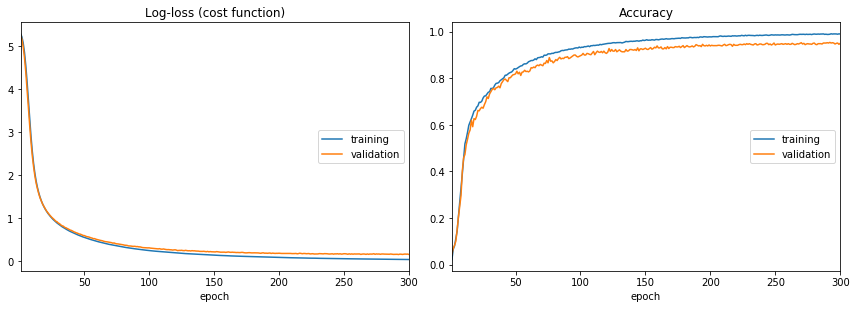

Log-loss (cost function):
training   (min:    0.042, max:    5.280, cur:    0.042)
validation (min:    0.158, max:    5.253, cur:    0.159)

Accuracy:
training   (min:    0.022, max:    0.991, cur:    0.990)
validation (min:    0.045, max:    0.954, cur:    0.950)
Train score: 0.03890234320797675
Train accuracy: 0.9911149825783973
Validation score: 0.1592121277014857
Validation accuracy: 0.9498607237358944


In [13]:
inputs = Input(shape=(500,))
hidden1 = Dense(128, activation="relu")(inputs)
hidden2 = Dense(64, activation="relu")(hidden1)
preds = Dense(200, activation="softmax")(hidden2)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=300, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

score_test = model.evaluate(X_test, y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Validation score:', score_val[0])
print('Validation accuracy:', score_val[1])

In [14]:
model.evaluate(X_test, y_test)

717/717 [==============================] - ETA:  - 0s 49us/step


[0.16584634353800298, 0.9470013947001394]

In [15]:
model.save_weights('Guitar_fret_spectral_NN_weights.h5')

In [16]:
with open('Guitar_fret_spectral_NN_architecture.json', 'w') as f:
    f.write(model.to_json())